In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

## 0. Import module

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import os
from torchsummary import summary
from torchvision import transforms                                                                                                                                        
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
from PIL import Image

import sys
sys.path.append("../src/")
import model
from datasets import imagenet
import config
#from utils.function import init_logging, init_environment, preprocess_image,\
#         recreate_image, get_lr, save_image
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map

## Hyperparameter

In [3]:
# resume = "037-0"
# model_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/models"
backbone = "resnet18"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load modal from dict

In [25]:
# model
net = model.Network(backbone=backbone, num_classes=1000, activations=True, 
                    pretrained=True)
net.to(device)
# resume from model
# resume_exp = resume.split("-")[0]
# resume_epoch = resume.split("-")[1]
# print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
# resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
# ckpt = torch.load(resume_path, map_location=device)
# net.load_state_dict(ckpt) 

Network(
  (model): ResNet18(
    (resnet18): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm

In [5]:
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 3.1 Load Original Data 

In [5]:
# Load data
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
reverse_mean = [-0.485, -0.456, -0.406]
reverse_std = [1/0.229, 1/0.224, 1/0.225]
train_transform = None
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    # transforms.RandomCrop(input_size),                                                                                                                              
    # transforms.RandomHorizontalFlip(),                                                                                                                              
    # transforms.ColorJitter(brightness=0.4, saturation=0.4, hue=0.4),                                                                                                
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", is_train=True, transform=train_transform)

trainset.set_data([950], 30)
#image, label, imgs_path = trainset
imgs_path = []                                                                                                                                                            
images = []
labels = []
for img, label, img_path in trainset:                                                                                                                                     
    images.append(img.unsqueeze(0))                                                                                                                                       
    labels.append(label)                                                                                                                                                  
    imgs_path.append(img_path)  

Len of new dataset is :30


## 3.2 Create some need path

In [24]:
# save_dir = "../saved/pack/"
# ################### Hyper-Parameter #######################
# exp = resume_exp
# epoch = resume_epoch
# ##########################################################
# ab_path = os.path.join(save_dir, exp, epoch)

In [8]:
index2image = {index: item.split("/")[-1].split(".")[0] for index, item in enumerate(imgs_path)}
index2image

{0: 'n07747607_10061',
 1: 'n07747607_10068',
 2: 'n07747607_10110',
 3: 'n07747607_10134',
 4: 'n07747607_10162',
 5: 'n07747607_10166',
 6: 'n07747607_10178',
 7: 'n07747607_10179',
 8: 'n07747607_10184',
 9: 'n07747607_10192',
 10: 'n07747607_10204',
 11: 'n07747607_10205',
 12: 'n07747607_1021',
 13: 'n07747607_10213',
 14: 'n07747607_10217',
 15: 'n07747607_10232',
 16: 'n07747607_10258',
 17: 'n07747607_10290',
 18: 'n07747607_10305',
 19: 'n07747607_10345',
 20: 'n07747607_10358',
 21: 'n07747607_10379',
 22: 'n07747607_10420',
 23: 'n07747607_10425',
 24: 'n07747607_10436',
 25: 'n07747607_10465',
 26: 'n07747607_10482',
 27: 'n07747607_10485',
 28: 'n07747607_10491',
 29: 'n07747607_10545'}

In [23]:
# save_dict = {
#     "save_dir": "/home/lincolnzjx/Desktop/Interpretation/saved/pack/"+ exp + "/feature_map/",
#     "index2image": index2image, 
#     "save_name": "layer-{}-{}.pdf"
# }
# 
# try: 
#     os.mkdir(save_dict["save_dir"])
# except FileExistsError:
#     print("Directory has been created {}".format(save_dict["save_dir"]))

In [6]:
# Move to device
original_image = torch.cat(images, dim=0).to(device)

## Visualization Here.

In [7]:
color_map = "nipy_spectral"
img_index = 12


resnet18
conv1
bn1
relu
=> Register fhook relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc
Plot mode is => img_scale
Color map is => nipy_spectral
Top-k => [44, 11, 10, 25,

<Figure size 432x288 with 0 Axes>

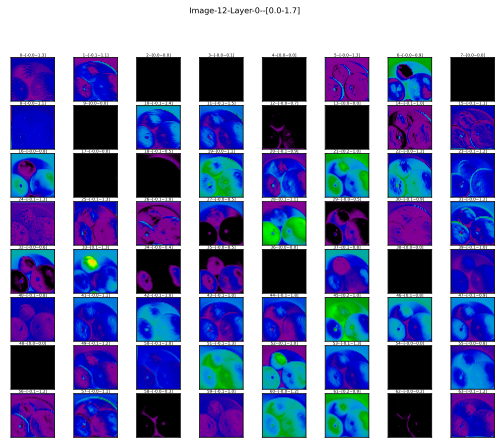

In [33]:
layer_name = "relu"
activation_maps = net.get_activation_maps(original_image, layer_name)
visualize_features_map(img_index=12, layer_index=0, 
                       features_map=activation_maps, cols=8, 
                       conv_output_index_dict={0:0}, save_dict=None, is_save=False,
                       plt_mode="img_scale", color_map=color_map)

In [29]:
layer_name = "layer1.0.relu"
activation_maps = net.get_activation_maps(original_image, layer_name)
visualize_features_map(img_index=12, layer_index=3, features_map=layer_output, cols=8, 
                       conv_output_index_dict=conv_output_indexes_dict, save_dict=save_dict, is_save=True,
                       plt_mode="img_scale", color_map=color_map)

NameError: name 'layer_output' is not defined

Plot mode is => img_scale
Color map is => nipy_spectral
Top-k => [17, 4, 114, 35, 123, 57, 84, 93, 2, 77]
Successfully Save pdf to /home/lincolnzjx/Desktop/Interpretation/saved/pack/037/feature_map/layer-6-n07747607_1021.pdf


<Figure size 432x288 with 0 Axes>

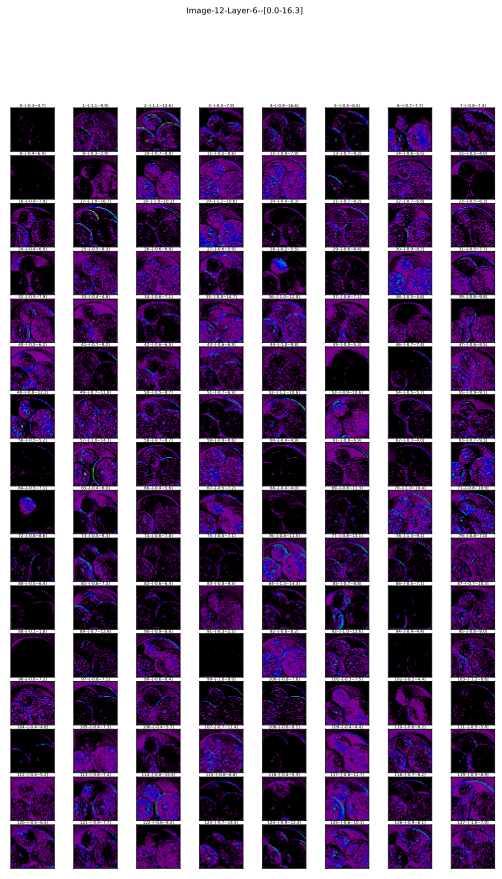

In [17]:
visualize_features_map(img_index=12, layer_index=6, features_map=layer_output, cols=8, 
                       conv_output_index_dict=conv_output_indexes_dict, save_dict=save_dict, is_save=True,
                       plt_mode="img_scale", color_map=color_map)

Plot mode is => img_scale
Color map is => nipy_spectral
Top-k => [2, 111, 106, 12, 28, 110, 38, 93, 27, 48]
Successfully Save pdf to /home/lincolnzjx/Desktop/Interpretation/saved/pack/037/feature_map/layer-8-n07747607_1021.pdf


<Figure size 432x288 with 0 Axes>

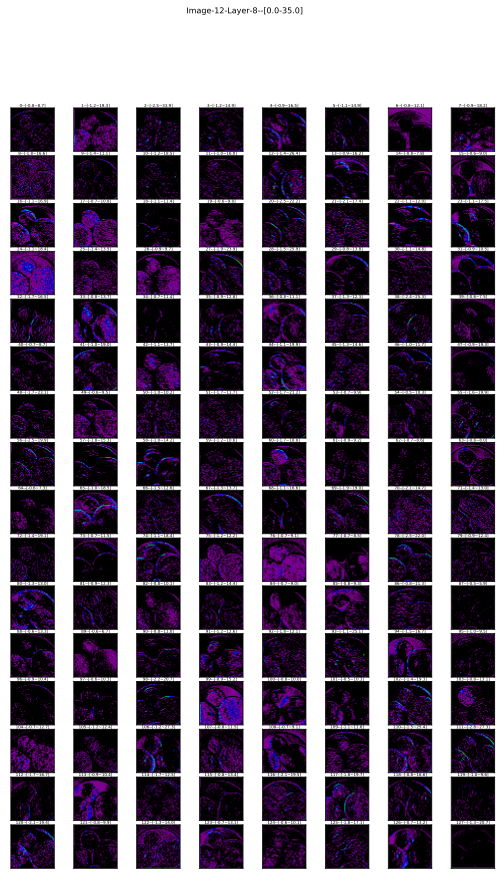

In [18]:
visualize_features_map(img_index=12, layer_index=8, features_map=layer_output, cols=8, 
                       conv_output_index_dict=conv_output_indexes_dict, save_dict=save_dict, is_save=True,
                       plt_mode="img_scale", color_map=color_map)

Plot mode is => img_scale
Color map is => nipy_spectral
Top-k => [185, 50, 241, 1, 84, 168, 215, 128, 240, 187]
Successfully Save pdf to /home/lincolnzjx/Desktop/Interpretation/saved/pack/037/feature_map/layer-11-n07747607_1021.pdf


<Figure size 432x288 with 0 Axes>

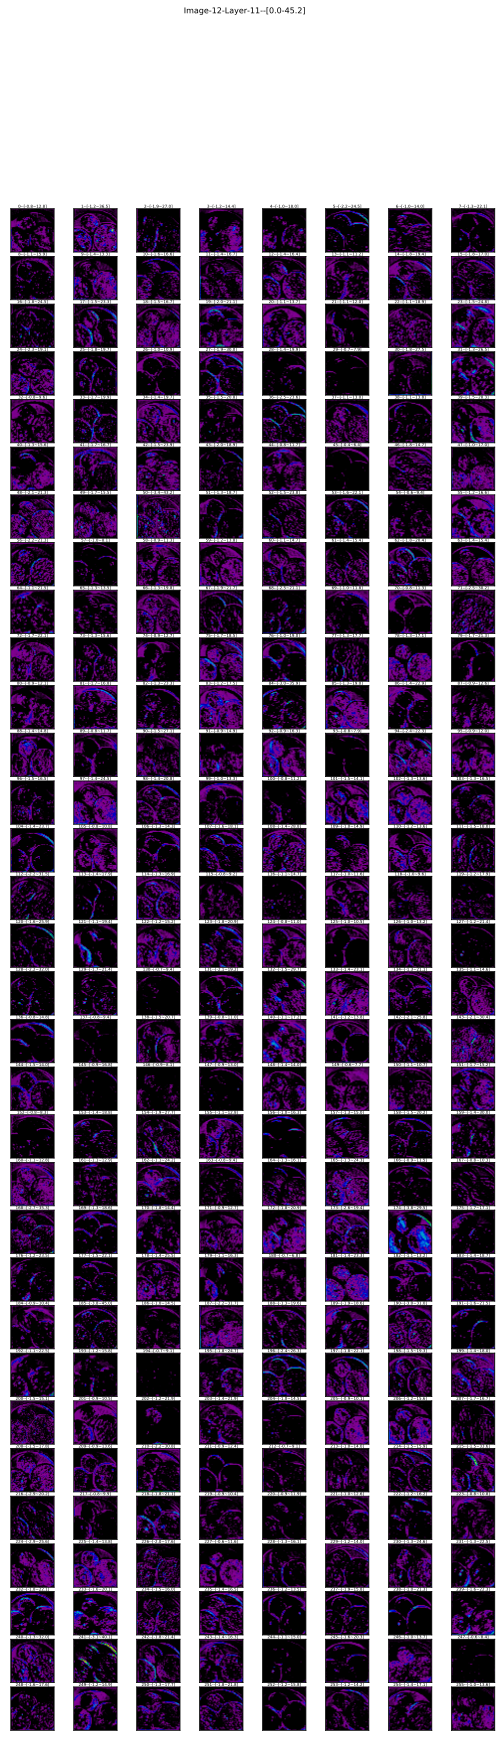

In [19]:
visualize_features_map(img_index=12, layer_index=11, features_map=layer_output, cols=8, 
                       conv_output_index_dict=conv_output_indexes_dict, save_dict=save_dict, is_save=True,
                       plt_mode="img_scale", color_map=color_map)

Plot mode is => img_scale
Color map is => nipy_spectral
Top-k => [252, 218, 87, 235, 71, 7, 146, 52, 245, 219]
Successfully Save pdf to /home/lincolnzjx/Desktop/Interpretation/saved/pack/037/feature_map/layer-13-n07747607_1021.pdf


<Figure size 432x288 with 0 Axes>

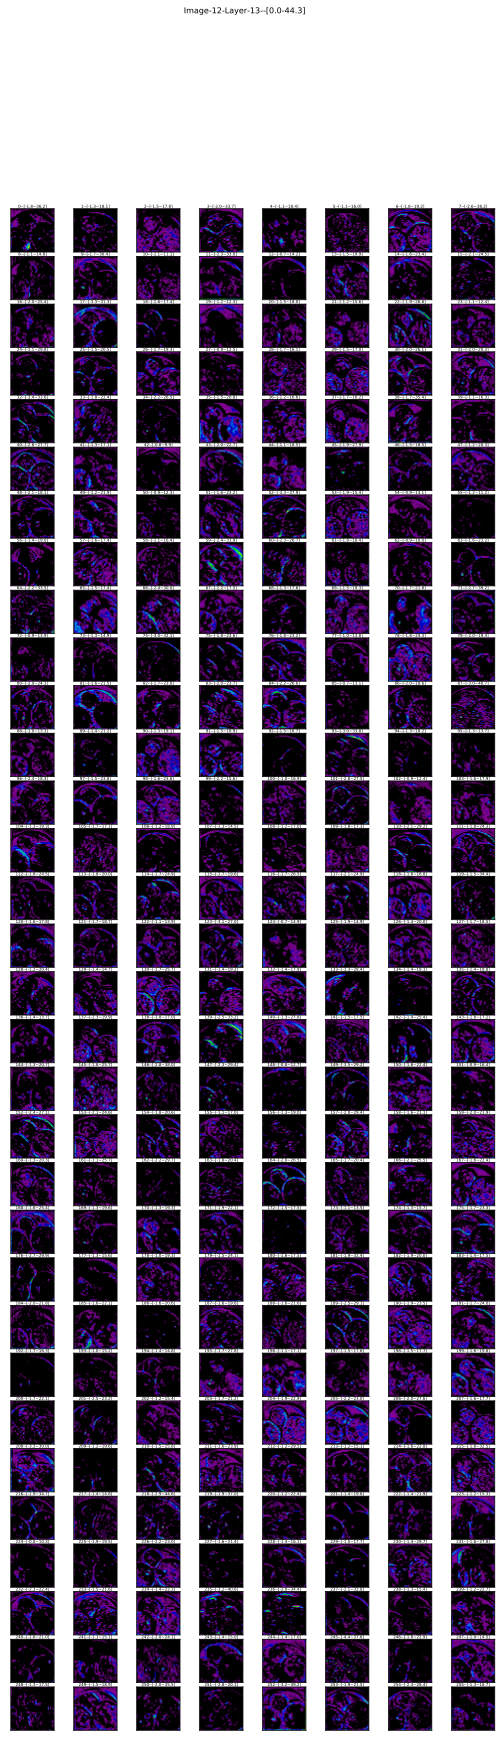

In [20]:
visualize_features_map(img_index=12, layer_index=13, features_map=layer_output, cols=8, 
                       conv_output_index_dict=conv_output_indexes_dict, save_dict=save_dict, is_save=True,
                       plt_mode="img_scale", color_map=color_map)

Plot mode is => img_scale
Color map is => nipy_spectral
Top-k => [223, 102, 14, 216, 26, 139, 24, 127, 90, 145]
Successfully Save pdf to /home/lincolnzjx/Desktop/Interpretation/saved/pack/037/feature_map/layer-15-n07747607_1021.pdf


<Figure size 432x288 with 0 Axes>

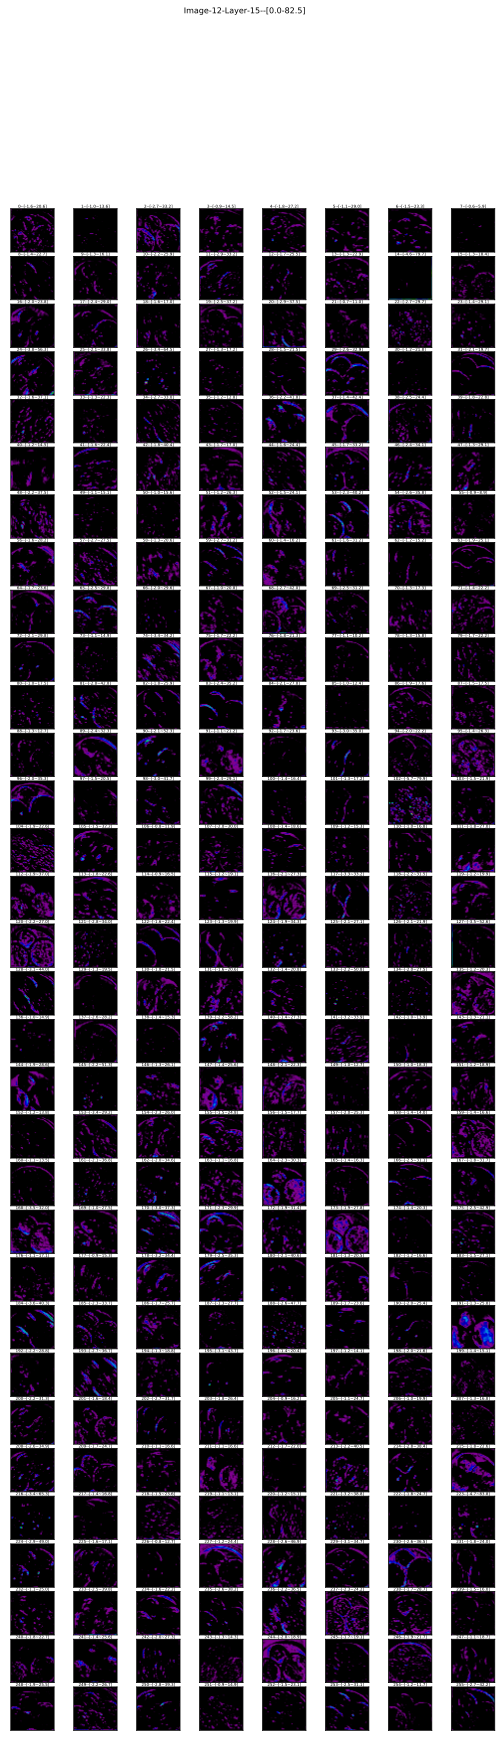

In [21]:
visualize_features_map(img_index=12, layer_index=15, features_map=layer_output, cols=8, 
                       conv_output_index_dict=conv_output_indexes_dict, save_dict=save_dict, is_save=True,
                       plt_mode="img_scale", color_map=color_map)